In [204]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth

import importlib

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import downloader 
import refcat
import imagehandler

importlib.reload(downloader)
importlib.reload(refcat)
importlib.reload(imagehandler)

<module 'imagehandler' from '/home/mikea/GitHub/shifty/shifty/imagehandler.py'>

In [205]:
filename = '../dev_data/2015RS281_HSC20160826_117.fits'
extno=0

In [206]:
with fits.open(filename) as han:
            data = han[extno].data
            header = han[extno].header  # Header for the extension
            header0 = han[0].header  # Overall header for mosaic, ext0
        

In [207]:
O=imagehandler.OneImage

In [208]:
o=O(filename)

In [209]:
o.data

array([[ 1.4440657e+04,  1.3562630e+04,  1.2861006e+04, ...,
         2.6882830e+04,  2.6882830e+04,  2.6882830e+04],
       [ 1.4440657e+04,  1.3562630e+04,  1.2861006e+04, ...,
         2.6882830e+04,  2.6882830e+04,  2.6882830e+04],
       [ 1.4440657e+04,  1.3562630e+04,  1.2861006e+04, ...,
         2.6882830e+04,  2.6882830e+04,  2.6882830e+04],
       ...,
       [-4.4729075e+00,  2.4267336e+01,  6.8557601e+00, ...,
         7.5015533e+01,  7.5015533e+01,  7.5015533e+01],
       [-3.5645054e+01, -1.0841467e+01, -2.4285862e+01, ...,
         3.7719433e+01,  3.7719433e+01,  3.7719433e+01],
       [-1.4335373e+01,  2.0109072e+00,  3.1635023e+01, ...,
         2.6642099e+01,  2.6642099e+01,  2.6642099e+01]], dtype=float32)

In [185]:
filenames=[filename.replace('117',str(i)) for i in np.arange(112, 124)]

In [186]:
E=imagehandler.ImageEnsemble(filenames,extno)

Set DATE-END to '2016-08-27T08:48:02.183' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T09:10:43.817' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T09:46:01.793' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T10:20:20.272' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T12:05:01.678' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T12:40:54.900' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T13:17:21.200' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T13:53:03.165' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T14:27:53.066' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T15:03:43.582' from MJD-END'. [astropy.wcs.wcs]


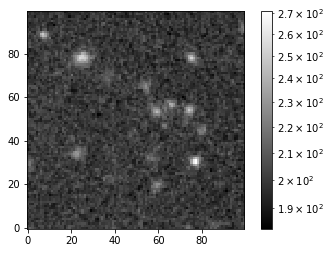

In [239]:
from matplotlib.colors import LogNorm
plt.imshow((E.data.mean(0)-E.data.mean(0).min())[230:330,100:200], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

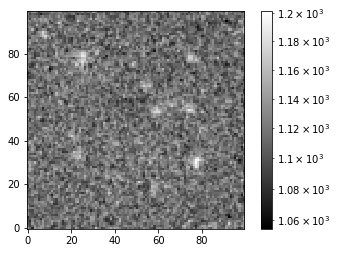

In [240]:
plt.imshow((E.data[11]-E.data[11].min())[230:330,100:200], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

Man, these 12 images are well aligned. Even without using the WCS, straight stacking results in much clearer images